In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

%matplotlib inline

In [2]:
#layers
def fc(inputs, num_output, activation_fn=None):
    return tf.contrib.layers.fully_connected(inputs, num_output, activation_fn=activation_fn)

def dropout(x, keep_prob):
    return tf.nn.dropout(x, keep_prob)

def lrelu(x, leak=0.2):
    return tf.maximum(x, leak*x)

def conv2d(inputs, num_outputs, filters=4, stride=2, padding='SAME', activation_fn=None, name=''):
    return tf.layers.conv2d(inputs, num_outputs, filters, stride, padding=padding, 
                                    activation=activation_fn, name=name)

def conv2d_transpose(inputs, num_outputs, filters=4, stride=2, padding='SAME', activation_fn=None, name=''):
    return tf.layers.conv2d_transpose(inputs, num_outputs, filters, stride,
                                             padding=padding, activation=activation_fn, name=name)

relu = tf.nn.relu

In [3]:
def cycle_consistency_loss(real, generated):
    return tf.reduce_mean(tf.abs(real - generated))
    
def lsgan_loss_discriminator(disc_real, disc_fake):
    real = tf.reduce_mean(tf.square(disc_real - tf.ones_like(disc_real)))
    fake = tf.reduce_mean(tf.square(disc_fake))        
    return (real+fake)*0.5
    
def lsgan_loss_generator(generated, c=1.0):
    return tf.reduce_mean(tf.square(generated - c))

In [4]:
def generator_conv(image, reuse=False, name="generator", filter_dim=64):
    with tf.variable_scope(name, reuse=reuse):
        encode_1 = conv2d(image, filter_dim, name="g_enc_1") #256*256 --> 128*128
        encode_2 = conv2d(lrelu(encode_1), filter_dim*2, name="g_enc_2") #128*128 --> 64*64
        encode_3 = conv2d(lrelu(encode_2), filter_dim*4, name="g_enc_3") #64*64 --> 32*32
        encode_4 = conv2d(lrelu(encode_3), filter_dim*4, name="g_enc_4") #32*32 --> 16*16
        encode_5 = conv2d(lrelu(encode_4), filter_dim*4, name="g_enc_5") #16*16 --> 8*8
        encode_6 = conv2d(lrelu(encode_5), filter_dim*4, name="g_enc_6") #8*8 --> 4*4
        encode_7 = conv2d(lrelu(encode_6), filter_dim*4, name="g_enc_7") #4*4 --> 2*2
        encode_8 = conv2d(lrelu(encode_7), filter_dim*4, name="g_enc_8") #2*2 --> 1*1
        
        #Decoding back to 256*256
        decode_1 = conv2d_transpose(relu(encode_8), filter_dim*4, name="g_dec_1") #1*1 --> 2*2
        decode_2 = conv2d_transpose(relu(decode_1), filter_dim*4, name="g_dec_2") #2*2 --> 4*4
        decode_3 = conv2d_transpose(relu(decode_2), filter_dim*4, name="g_dec_3") #4*4 --> 8*8
        decode_4 = conv2d_transpose(relu(decode_3), filter_dim*4, name="g_dec_4") #8*8 --> 16*16
        decode_5 = conv2d_transpose(relu(decode_4), filter_dim*4, name="g_dec_5") #16*16 --> 32*32
        decode_6 = conv2d_transpose(relu(decode_5), filter_dim*4, name="g_dec_6") #32*32 --> 64*64
        decode_7 = conv2d_transpose(relu(decode_6), filter_dim*2, name="g_dec_7") #64*64 --> 128*128
        decode_8 = conv2d_transpose(relu(decode_7), 3, name="g_dec_8") #128*128 --> 256*256 (*3 image channels)
        
        return tf.nn.tanh(decode_8)

In [5]:
def discriminator_conv(image, reuse=False, name="discriminator", filter_dim=64):
    with tf.variable_scope(name, reuse=reuse):
        conv_1 = conv2d(image, filter_dim, name="d_conv_1") #256*256 --> 128*128
        conv_2 = conv2d(lrelu(conv_1), filter_dim*2, name="d_conv_2") #128*128 --> 64*64
        conv_3 = conv2d(lrelu(conv_2), filter_dim*4, name="d_conv_3") #64*64 --> 32*32
        conv_4 = conv2d(lrelu(conv_3), filter_dim*4, stride=1, name="d_conv_4") #32*32 --> 32*32
        conv_5 = conv2d(lrelu(conv_4), 1, stride=1, name="d_conv_5") #32*32*1
        
        return conv_5
        

In [6]:
from glob import glob
import scipy.misc

#These 2 functions are written only for apple2orange dataset which has RGB images of size 256*256
def load_images(img_paths, size=256):
    images = np.array([scipy.misc.imread(img, mode='RGB').astype(np.float32) for img in img_paths])
    #Not needed for this dataset as data is already 256*256
    #images = [scipy.misc.resize(img, [size, size]) for img in images]
    #Probably Normalizing data
    images = images/127.5 - 1.0
    return images
    
    
def load_apple_orange_data():
    train_a = glob('./data/apple2orange/trainA/*.*')
    train_b = glob('./data/apple2orange/trainB/*.*')
    test_a = glob('./data/apple2orange/testA/*.*')
    test_b = glob('./data/apple2orange/testB/*.*')
    
    train_a = load_images(train_a)
    train_b = load_images(train_b)
    test_a = load_images(test_a)
    test_b = load_images(test_b)
    
    return train_a, train_b, test_a, test_b

load_data = load_apple_orange_data

In [9]:
class CycleGAN(object):
    
    def __init__(self, lr=0.005, img_ht=256, img_wd=256, img_ch=3, L1_lambda=10.0, batch_size=1, epochs=10):
        self.lr = lr
        self.img_ht = img_ht
        self.img_wd = img_wd
        self.img_ch = img_ch
        self.L1_lambda = L1_lambda
        self.batch_size = batch_size
        self.epochs = epochs
        self.generator = generator_conv
        self.discriminator = discriminator_conv
        
        self.inputs()
        self.model()
        self.loss()
        self.optimize()
        self.config = tf.ConfigProto(allow_soft_placement = True)
        self.sess = tf.Session(config=self.config)
        #self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
    
    def inputs(self):
        self.a_real = tf.placeholder(tf.float32, [None, self.img_ht, self.img_wd, self.img_ch])
        self.b_real = tf.placeholder(tf.float32, [None, self.img_ht, self.img_wd, self.img_ch])
        
        self.a2b_sample = tf.placeholder(tf.float32, [None, self.img_ht, self.img_wd, self.img_ch])
        self.b2a_sample = tf.placeholder(tf.float32, [None, self.img_ht, self.img_wd, self.img_ch])
    
    def model(self):
        self.a2b = self.generator(self.a_real, name='generator_a2b')
        self.b2a = self.generator(self.b_real, name='generator_b2a')
        self.a2b2a = self.generator(self.a2b, name='generator_b2a', reuse=True)
        self.b2a2b = self.generator(self.b2a, name='generator_a2b', reuse=True)
        
        self.a_dis = self.discriminator(self.a_real, name='discriminator_a')
        self.b2a_dis = self.discriminator(self.b2a, name='discriminator_a', reuse=True)
        self.b_dis = self.discriminator(self.b_real, name='discriminator_b')
        self.a2b_dis = self.discriminator(self.a2b, name='discriminator_b', reuse=True)
        
        self.a2b_sample_dis = self.discriminator(self.a2b_sample, name='discriminator_b', reuse=True)
        self.b2a_sample_dis = self.discriminator(self.b2a_sample, name='discriminator_a', reuse=True)
        
    def loss(self):
        self.gen_loss_a2b = lsgan_loss_generator(self.a2b_dis)
        self.gen_loss_b2a = lsgan_loss_generator(self.b2a_dis)
        self.gen_cyc_loss_a = cycle_consistency_loss(self.a_real, self.a2b2a)
        self.gen_cyc_loss_b = cycle_consistency_loss(self.b_real, self.b2a2b)
        self.gen_loss = self.gen_loss_a2b + self.gen_loss_b2a + \
                        self.L1_lambda*(self.gen_cyc_loss_a + self.gen_cyc_loss_b)
        
        self.dis_loss_a = lsgan_loss_discriminator(self.a_dis, self.b2a_sample_dis)
        self.dis_loss_b = lsgan_loss_discriminator(self.b_dis, self.a2b_sample_dis)
        self.dis_loss = self.dis_loss_a + self.dis_loss_b
        
    def optimize(self):
        train_vars = tf.trainable_variables()
        gen_vars = [var for var in train_vars if var.name.startswith('generator')]
        dis_vars = [var for var in train_vars if var.name.startswith('discriminator')]
        
        self.dis_opt = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(self.dis_loss, var_list=dis_vars)
        self.gen_opt = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(self.gen_loss, var_list=gen_vars)
        
    def generate_b2a(self, img_b):
        return self.sess.run(self.b2a,
                        feed_dict={self.b_real: img_b})
        
    def generate_a2b(self, img_a):
        return self.sess.run(self.a2b, 
                        feed_dict={self.a_real: img_a})
        
    def train(self):
        train_a, train_b, test_a, test_b = load_data()
        
        with tf.device('/gpu:0'):
            for epoch in range(self.epochs):
                np.random.shuffle(train_a)
                np.random.shuffle(train_b)
                batch_ids = np.minimum(len(train_a), len(train_b)) // self.batch_size
            
                for ii in range(0, batch_ids):
                    batch_a = train_a[(ii*self.batch_size): ((ii+1)*self.batch_size)]
                    batch_b = train_b[(ii*self.batch_size): ((ii+1)*self.batch_size)]
                
                    #Get fake_A, fake_B samples and run gen_opt
                    fake_a, fake_b, _ = self.sess.run([self.b2a, self.a2b, self.gen_opt],
                                                      feed_dict={self.a_real: batch_a,
                                                                 self.b_real: batch_b,
                                                                })
                
                    self.sess.run([self.dis_opt],
                                  feed_dict={self.a_real: batch_a,
                                             self.b_real: batch_b,
                                             self.b2a_sample: fake_a,
                                             self.a2b_sample: fake_b,
                                            })
                
                dis_loss, gen_loss = self.sess.run([self.dis_loss, self.gen_loss],
                                                   feed_dict={self.a_real: batch_a,
                                                              self.b_real: batch_b,
                                                              self.b2a_sample: fake_a,
                                                              self.a2b_sample: fake_b,
                                                             })
            
                print ("Epoch {} Discriminator Loss: {} Generator Loss: {}"
                       .format(epoch, dis_loss, gen_loss))

In [15]:
tf.reset_default_graph()

model = CycleGAN()
model.train()

c:\users\ljgun\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


Epoch 0 Discriminator Loss: 3.0042917728424072 Generator Loss: 23.17581558227539
Epoch 1 Discriminator Loss: 19.896438598632812 Generator Loss: 18.563594818115234
Epoch 2 Discriminator Loss: 0.8922874927520752 Generator Loss: 17.507787704467773
Epoch 3 Discriminator Loss: 3.5365781784057617 Generator Loss: 20.297401428222656
Epoch 4 Discriminator Loss: 0.4804787039756775 Generator Loss: 18.654340744018555
Epoch 5 Discriminator Loss: 62701864.0 Generator Loss: 49248680.0
Epoch 6 Discriminator Loss: 78536720.0 Generator Loss: 10186724.0
Epoch 7 Discriminator Loss: 39872320.0 Generator Loss: 6820666.5
Epoch 8 Discriminator Loss: 19637666.0 Generator Loss: 124037.1484375
Epoch 9 Discriminator Loss: 3280798.5 Generator Loss: 152194.34375


In [33]:
testA = load_images(glob('./data/apple2orange/testA/*.*'))

img = model.generate_a2b(np.array([testA[0]]))
#plt.show(img)

c:\users\ljgun\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


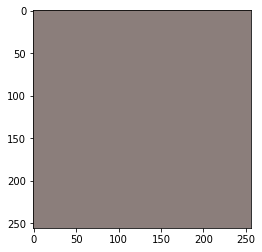

In [34]:
img_ = img[0]
img_ = (img_+1.0)/2.0
plt.imshow(img_)